In [33]:
# Note to import from .py files, must follow structure
# from <.py filename excluding '.py'> import <class name>

# Importing necessary models
import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.dates as dates
import matplotlib.ticker as ticker
from lxml import html
import requests
import webbrowser
from bs4 import BeautifulSoup as bs
import json
import csv
import sched, time
from pandas_datareader.data import Options
from py_vollib.black_scholes_merton.implied_volatility import *
import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import plotly.plotly as py
import plotly
import statsmodels.api as sm
from scipy.stats import skewnorm as skn
from scipy.stats import norm
import statsmodels.api as sm
import plotly.graph_objs as go
import plotly.figure_factory as ff
%matplotlib inline

# Using plotly api_key credentials
# plotly.tools.set_credentials_file(username='aspiringfastlaner', api_key='')
# Pulling all historical data and collapsing into raw dataframe for use
from rawdatapull import datacollect

ModuleNotFoundError: No module named 'dash'

In [5]:
# Pulling Yahoo live data

'''
Function for pulling latest SPX, VIX, VVIX, or SKEW data. Input is a string, pulls 
the latest 2 lines of data from yahoo finance for given ticker and returns a 
dataframe of the open and close with the latest date as the first row.
'''
def latest_yahoo(ticker = 'SPX'):
    # Using requests to ping yahoo finance to retrieve 
    # historical data table
    if ticker == 'VIX':
        site = 'https://finance.yahoo.com/quote/%5EVIX/history?p=^VIX'
    elif ticker == 'VVIX':
        site = 'https://finance.yahoo.com/quote/%5EVVIX/history?p=^VVIX'
    elif ticker == 'SKEW':
        site = 'https://finance.yahoo.com/quote/%5ESKEW/history?p=^SKEW'
    else:
        site = 'https://finance.yahoo.com/quote/%5EGSPC/history?p=^GSPC'
        
    res = requests.get(site)
    soup = bs(res.text, 'lxml')
    table = soup.find_all('table')[0]

    # Initializing list to store date, open, and close values
    # for GSPC
    dates = []
    opens = []
    closes = []
    
    # Looping through the soup lxml text table format
    # and splitting each row as a individual string
    # and parsing string to retrieve the date,
    # open, and close information.
    i = 1
    end_row = 3
    for row in table.find_all('tr'):
        # Individual row stores current row item and delimits on '\n'
        individual_row = str(row).split('\n')
        
        # row_items is parsed string for each current row where each
        # item in list is the date, open, high, low, close, and volume
        row_items = [item.split('>')[1] for item in [string.split('</span>')[0] for string in individual_row[0].split('<span ')[1:]]]
        
        if i == 1:
            # Skip first row because they are column headers
            i += 1
            continue
        elif i == end_row:
            break
        else:
            # Append necessary items to initialized lists for 
            # dataframe storage
            dates.append(dt.datetime.strptime(row_items[0], '%b %d, %Y'))
            opens.append(float(row_items[1].replace(',','')))
            closes.append(float(row_items[5].replace(',','')))
        i += 1
    
    # Return dataframe of necessary values
    return pd.DataFrame({ticker + ' Open': opens,ticker + ' Close': closes}, index = dates)
    
'''
Function for pulling options data from yahoo Input is a string, either 'call' or 'put' to
determine the contract type to pull from yahoo finance. The output is a dataframe of the latest
data from yahoo finance tagged with the current date-time. Output columns are pull date-time,
contract name, strike, last price, bid, ask volume, open interest, and IV (in decimal form).
'''
def yahoo_options(contract = 'put'):
    # Using request to ping yahoo and retrieve the raw html
    # tables for calls and puts data for gspc
    site = 'https://finance.yahoo.com/quote/%5EGSPC/options?p=%5EGSPC'
    res = requests.get(site)
    soup = bs(res.text, 'lxml')
    calls = soup.find_all('table')[0]
    puts = soup.find_all('table')[1]
    if contract == 'call':
        table = calls
    else:
        table = puts
        
    # parsing calls table
    
    # initiating data lists for storing column data
    dates = []
    names = []
    strikes = []
    lprices = []
    bids = []
    asks = []
    volumes = []
    open_interests = []
    iv = []
    current_time = dt.datetime.now()
    
    # starting with counter i so that the first row in the
    # specified table is noted as the header row
    i = 1
    for row in table.find_all('tr'):
        rowstring = str(row).split('\n')
        # if first row, store data as header labels for dataframe use
        if i == 1:
            header = [data.split('>')[1] for data in \
                        [rawstring.split('</span>')[0] for \
                         rawstring in rowstring[0].split('<span')[1:]]]
        else:
        # parsing other raw row strings to retrieve necessary data and append them
        # to their corresponding list.
            row_data = rowstring[0].split('data-reactid=')[3:]
            dates.append(current_time)
            names.append(row_data[0].split('title="')[1].split('"')[0])
            strikes.append(float(row_data[3].split('</a>')[0].split('>')[1].replace(',','')))
            lprices.append(float(row_data[4].split('</td>')[0].split('>')[1].replace(',','')))
            bids.append(float(row_data[5].split('</td>')[0].split('>')[1].replace(',','')))
            asks.append(float(row_data[6].split('</td>')[0].split('>')[1].replace(',','')))
            volumes.append(float(row_data[-3].split('</td>')[0].split('>')[1].replace(',','')))
            open_interests.append(float(row_data[-2].split('</td>')[0].split('>')[1].replace(',','')))
            iv.append(float(row_data[-1].split('</td>')[0].split('>')[1].replace(',','').replace('%',''))/100)
        i += 1

    return pd.DataFrame({'Pull Date': dates,
                          contract + ' ' + header[0]: names,
                          header[2]: strikes,
                          header[3]: lprices,
                          header[4]: bids,
                          header[5]: asks,
                          header[-3]: volumes,
                          header[-2]: open_interests,
                          header[-1]: iv})
'''
Similar to above, the yahoo_historical function scrapes data from yahoo finance. This time
it scrapes all historical data from yahoo finance and stores in a data frame. Only used for
VVIX and SPX index
'''

# Use six to import urllib so it is working for Python2/3
from six.moves import urllib
# If you don't want to use six, please comment out the line above
# and use the line below instead (for Python3 only).
#import urllib.request, urllib.parse, urllib.error

import time

'''
Starting on May 2017, Yahoo financial has terminated its service on
the well used EOD data download without warning. This is confirmed
by Yahoo employee in forum posts.
Yahoo financial EOD data, however, still works on Yahoo financial pages.
These download links uses a "crumb" for authentication with a cookie "B".
This code is provided to obtain such matching cookie and crumb.
'''

# Build the cookie handler
cookier = urllib.request.HTTPCookieProcessor()
opener = urllib.request.build_opener(cookier)
urllib.request.install_opener(opener)

# Cookie and corresponding crumb
_cookie = None
_crumb = None

_headers={'User-Agent': 'Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11'}

def get_cookie_crumb():
    '''
    This function perform a query and extract the matching cookie and crumb.
    '''

    # Perform a Yahoo financial lookup on SP500
    req = urllib.request.Request('https://finance.yahoo.com/quote/^GSPC', headers=_headers)
    f = urllib.request.urlopen(req)
    alines = f.read().decode('utf-8')

    # Extract the crumb from the response
    global _crumb
    cs = alines.find('CrumbStore')
    cr = alines.find('crumb', cs + 10)
    cl = alines.find(':', cr + 5)
    q1 = alines.find('"', cl + 1)
    q2 = alines.find('"', q1 + 1)
    crumb = alines[q1 + 1:q2]
    _crumb = crumb

    # Extract the cookie from cookiejar
    global cookier, _cookie
    for c in cookier.cookiejar:
        if c.domain != '.yahoo.com':
            continue
        if c.name != 'B':
            continue
    _cookie = c.value

    # Print the cookie and crumb
    # print('Cookie:', _cookie)
    # print('Crumb:', _crumb)
    return _crumb


def yahoo_historical(ticker = 'SPX'):
    # Using requests to ping yahoo finance to retrieve 
    # historical data table
    
    # Getting cookie crumb for yahoo finance query
    get_cookie_crumb()
    
    if ticker == 'VVIX':
        site = 'https://query1.finance.yahoo.com/v7/finance/download/%5EVVIX?period1=1167811200&period2=' + str(int(time.time())) + '&interval=1d&events=history&crumb=' + get_cookie_crumb().replace('\\','')
    else:
        site = 'https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=-630950400&period2=' + str(int(time.time())) + '&interval=1d&events=history&crumb=' + get_cookie_crumb().replace('\\','')
    
    df = pd.read_csv(site)
    return df

In [6]:
spx = yahoo_historical()

In [8]:
spx.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
17143,2018-02-20,2722.989990,2737.600098,2706.760010,2716.260010,2716.260010,3627610000
17144,2018-02-21,2720.530029,2747.750000,2701.290039,2701.330078,2701.330078,3779400000
17145,2018-02-22,2710.419922,2731.260010,2697.770020,2703.959961,2703.959961,3701270000
17146,2018-02-23,2715.800049,2747.760010,2713.739990,2747.300049,2747.300049,3189190000
17147,2018-02-26,2757.370117,2780.639893,2753.780029,2779.600098,2779.600098,3424650000
17148,2018-02-27,2780.449951,2789.149902,2744.219971,2744.280029,2744.280029,3745080000
17149,2018-02-28,2753.780029,2761.520020,2713.540039,2713.830078,2713.830078,4230660000
17150,2018-03-01,2715.219971,2730.889893,2659.649902,2677.669922,2677.669922,4503970000
17151,2018-03-02,2658.889893,2696.250000,2647.320068,2691.250000,2691.250000,3882450000
17152,2018-03-05,2681.060059,2728.090088,2675.750000,2720.939941,2720.939941,2341946665


In [12]:
df = spx

In [22]:
df['SPY returns'] = df['Adj Close'].pct_change()
df['fwd returns'] = df['Open'].pct_change().shift(-2)
df['hist vol'] = df['SPY returns'].rolling(21).std() * np.sqrt(252) * 100
df['fwd vol'] = df['SPY returns'].rolling(21).std().shift(-21) * np.sqrt(252) * 100

In [23]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,SPY returns,fwd returns,hist vol,fwd vol
0,1950-01-03,16.660000,16.660000,16.660000,16.660000,16.660000,1260000,NaN,0.004748,NaN,10.734942
1,1950-01-04,16.850000,16.850000,16.850000,16.850000,16.850000,1890000,0.011405,0.002953,NaN,10.636262
2,1950-01-05,16.930000,16.930000,16.930000,16.930000,16.930000,2550000,0.004748,0.006478,NaN,10.590274
3,1950-01-06,16.980000,16.980000,16.980000,16.980000,16.980000,2010000,0.002953,-0.003511,NaN,10.570695
4,1950-01-09,17.090000,17.090000,17.080000,17.080000,17.080000,3850000,0.005889,0.003523,NaN,10.617539
5,1950-01-10,17.030001,17.030001,17.030001,17.030001,17.030001,2160000,-0.002927,-0.019310,NaN,10.564495
6,1950-01-11,17.090000,17.090000,17.090000,17.090000,17.090000,2630000,0.003523,-0.005370,NaN,10.585643
7,1950-01-12,16.760000,16.760000,16.760000,16.760000,16.760000,2970000,-0.019310,-0.001200,NaN,7.853125
8,1950-01-13,16.670000,16.670000,16.670000,16.670000,16.670000,3330000,-0.005370,0.012613,NaN,8.564681
9,1950-01-16,16.650000,16.719999,16.650000,16.719999,16.719999,2640000,0.002999,-0.000593,NaN,8.544563


In [24]:
volatilities = df[['hist vol', 'fwd vol']].dropna()
volatilities.corr()

,hist vol,fwd vol
hist vol,1.000000,0.663369
fwd vol,0.663369,1.000000


In [34]:
sns.pairplot(volatilities)

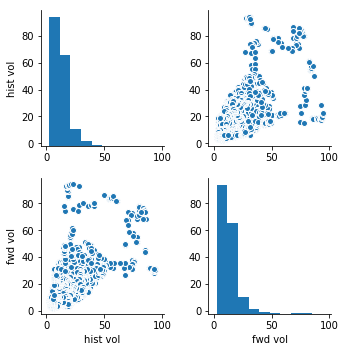

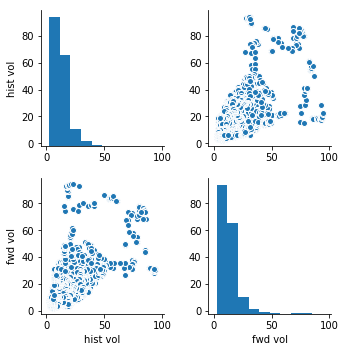

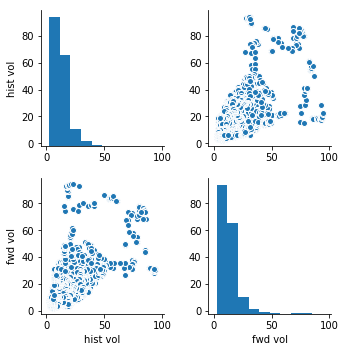

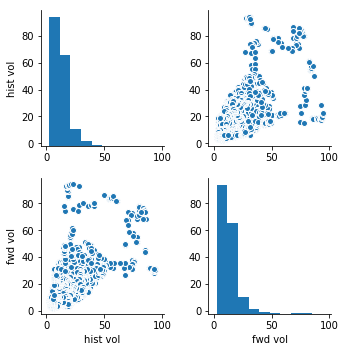

In [38]:
plt.show()

In [27]:
currentpath = os.getcwd()

In [39]:
currentpath = currentpath + "\\^VIX.csv"

In [41]:
VIX = pd.read_csv('^VIX.csv')

In [42]:
VIX.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-01-02,17.240000,17.240000,17.240000,17.240000,17.240000,0
1,1990-01-03,18.190001,18.190001,18.190001,18.190001,18.190001,0
2,1990-01-04,19.219999,19.219999,19.219999,19.219999,19.219999,0
3,1990-01-05,20.110001,20.110001,20.110001,20.110001,20.110001,0
4,1990-01-08,20.260000,20.260000,20.260000,20.260000,20.260000,0
5,1990-01-09,22.200001,22.200001,22.200001,22.200001,22.200001,0
6,1990-01-10,22.440001,22.440001,22.440001,22.440001,22.440001,0
7,1990-01-11,20.049999,20.049999,20.049999,20.049999,20.049999,0
8,1990-01-12,24.639999,24.639999,24.639999,24.639999,24.639999,0
9,1990-01-15,26.340000,26.340000,26.340000,26.340000,26.340000,0
